In [2]:
# Step 0 — Imports
import os, io, zipfile, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance


In [5]:
# Step 2
from google.colab import files

uploaded = files.upload()  # <-- This opens the file chooser

# Save uploaded files and auto-unzip if needed
csv_candidates = []

for name, data in uploaded.items():
    path = f"/content/{name}"
    with open(path, "wb") as f:
        f.write(data)

    if name.lower().endswith(".zip"):
        print(f"Unzipping: {name}")
        with zipfile.ZipFile(io.BytesIO(data)) as z:
            z.extractall("/content")
    elif name.lower().endswith(".csv"):
        csv_candidates.append(path)

if not csv_candidates:
    csv_candidates = glob.glob("/content/**/*.csv", recursive=True) + glob.glob("/content/*.csv")

if not csv_candidates:
    raise FileNotFoundError("No CSV found. Please upload a CSV or a ZIP containing CSV(s).")

csv_path = None
for p in csv_candidates:
    if os.path.basename(p).lower() == "housing.csv":
        csv_path = p
        break
if csv_path is None:
    csv_path = csv_candidates[0]

print(f"Selected CSV: {csv_path}")


Saving Housing.csv to Housing (1).csv
Selected CSV: /content/Housing (1).csv


In [6]:
# Step 3 — Load and peek
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())


Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished



Columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6)

In [7]:
# Step 4
# Kaggle file typically has: area, bedrooms, price, furnishingstatus
rename_map = {}
cols_lower = {c.lower(): c for c in df.columns}

if "area" in cols_lower:          rename_map[cols_lower["area"]] = "Size"
if "bedrooms" in cols_lower:      rename_map[cols_lower["bedrooms"]] = "Number of Rooms"
if "price" in cols_lower:         rename_map[cols_lower["price"]] = "Price"

if "furnishingstatus" in cols_lower:
    rename_map[cols_lower["furnishingstatus"]] = "Location"

df = df.rename(columns=rename_map)

required = ["Size", "Number of Rooms", "Price"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Required columns missing after mapping: {missing}\nAvailable: {df.columns.tolist()}")

if "Location" not in df.columns:
    # Try some other categorical columns if present
    cat_cols = [c for c in df.columns if df[c].dtype == "object" and c not in ["Price"]]
    if cat_cols:
        df = df.rename(columns={cat_cols[0]: "Location"})
        print(f"'Location' not found; using '{cat_cols[0]}' as 'Location'.")
    else:
        # If truly none, create a single dummy category
        df["Location"] = "Unknown"
        print("No categorical column found; created dummy 'Location'='Unknown'.")

# Drop rows with missing target
df = df.dropna(subset=["Price"]).reset_index(drop=True)
print("Final columns:", df.columns.tolist())
display(df.head())


Final columns: ['Price', 'Size', 'Number of Rooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'Location']


,Price,Size,Number of Rooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,Location
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


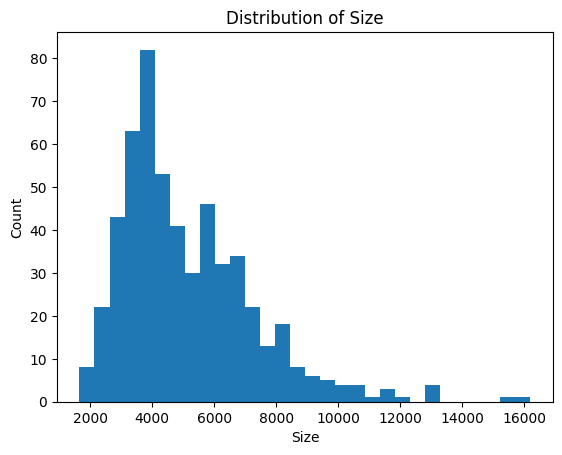

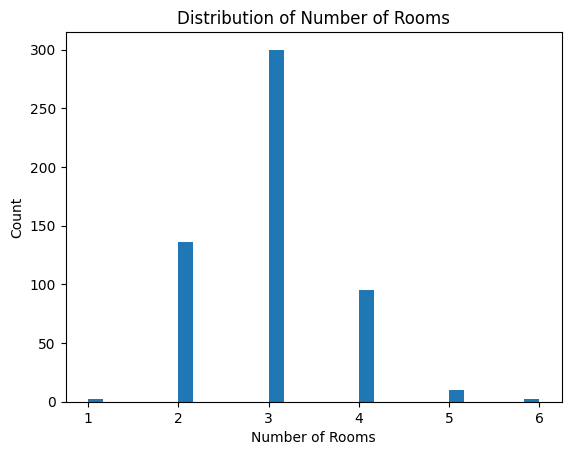

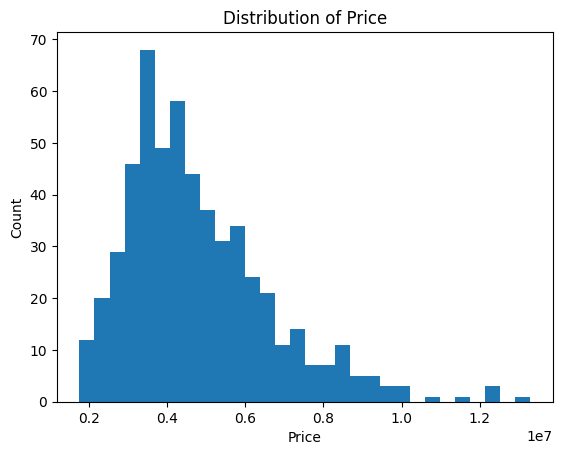

Outlier summary (IQR):


,Q1,Q3,IQR,Lower,Upper,Outliers
Size,3600.0,6360.0,2760.0,-540.0,10500.0,12.0
Number of Rooms,2.0,3.0,1.0,0.5,4.5,12.0
Price,3430000.0,5740000.0,2310000.0,-35000.0,9205000.0,15.0


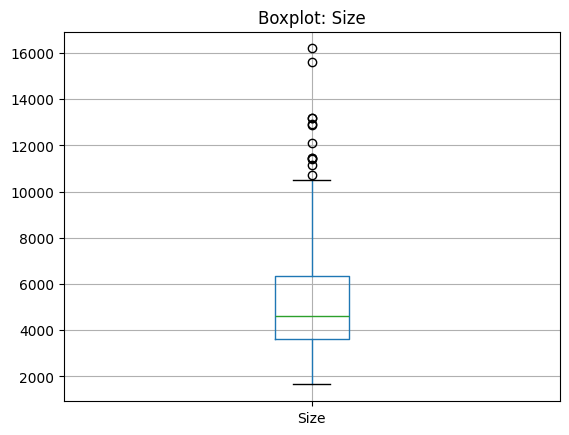

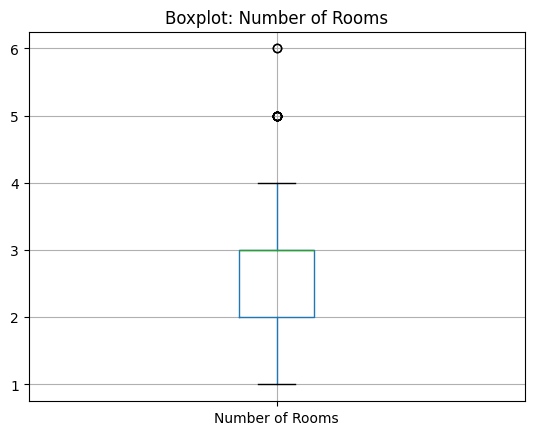

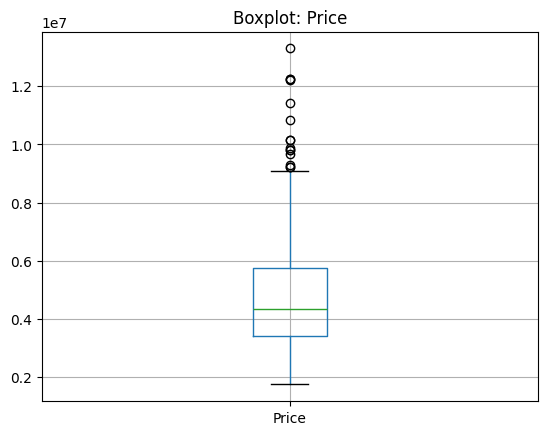

In [8]:
# Step 5 — Distributions (numerical)
for col in ["Size", "Number of Rooms", "Price"]:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

# Outlier summary via IQR
def outlier_summary(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return pd.Series({"Q1": q1, "Q3": q3, "IQR": iqr, "Lower": lo, "Upper": hi,
                      "Outliers": ((s < lo) | (s > hi)).sum()})

summary = pd.concat({c: outlier_summary(df[c]) for c in ["Size", "Number of Rooms", "Price"]}, axis=1).T
print("Outlier summary (IQR):")
display(summary)

#show boxplots
for col in ["Size", "Number of Rooms", "Price"]:
    plt.figure()
    df[[col]].boxplot()
    plt.title(f"Boxplot: {col}")
    plt.show()


In [9]:
# Step 6 — Correlation with Price
corr = df[["Size", "Number of Rooms", "Price"]].corr()
print("\nCorrelation matrix:")
display(corr)
print("\nCorrelation with Price:")
print(corr["Price"])



Correlation matrix:


,Size,Number of Rooms,Price
Size,1.000000,0.151858,0.535997
Number of Rooms,0.151858,1.000000,0.366494
Price,0.535997,0.366494,1.000000



Correlation with Price:
Size               0.535997
Number of Rooms    0.366494
Price              1.000000
Name: Price, dtype: float64


In [10]:
# Step 7 — Features & target
X = df[["Size", "Number of Rooms", "Location"]]
y = df["Price"]

numeric_features = ["Size", "Number of Rooms"]
categorical_features = ["Location"]


In [11]:
# Step 8 — Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Handle sklearn version differences for OneHotEncoder argument
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


In [12]:
# Step 9 — Split (80/20, reproducible)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
len(X_train), len(X_test)


(436, 109)

In [13]:
# Step 10 — Model training
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("lr", LinearRegression())
])

model.fit(X_train, y_train)
print("Model trained.")


Model trained.


In [14]:
# Step 11 — Predict and inspect
y_pred = model.predict(X_test)
pred_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
display(pred_df.head())

# Save predictions
pred_path = "/content/test_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print(f"Saved predictions to: {pred_path}")


,Actual,Predicted
0,4060000,5.165997e+06
1,6650000,5.729924e+06
2,3710000,3.736045e+06
3,6440000,4.738576e+06
4,2800000,4.794470e+06


Saved predictions to: /content/test_predictions.csv


In [16]:
# Step 12 — Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R² Score
r2 = r2_score(y_test, y_pred)

print("📊 Model Evaluation Results")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


📊 Model Evaluation Results
RMSE : 1786816.36
R²   : 0.3684


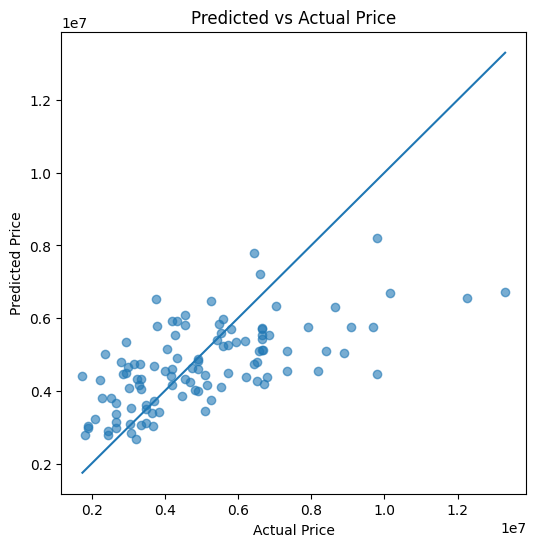

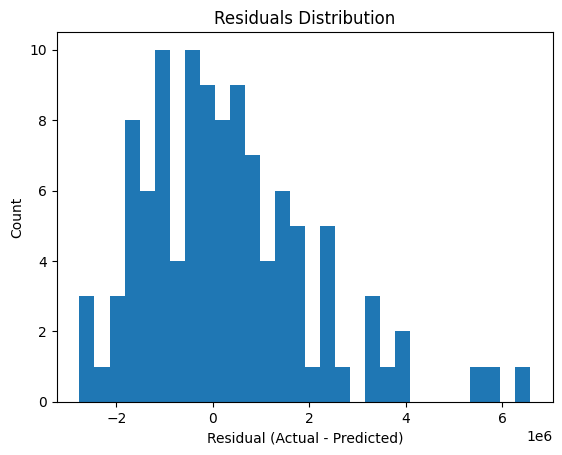

In [17]:
# Step 13 — Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual Price"); plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price")
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()


Feature Importance:
           Feature  Importance_Mean  Importance_Std
0             Size         0.312555        0.056475
1  Number of Rooms         0.125866        0.039378
2         Location         0.059463        0.025462


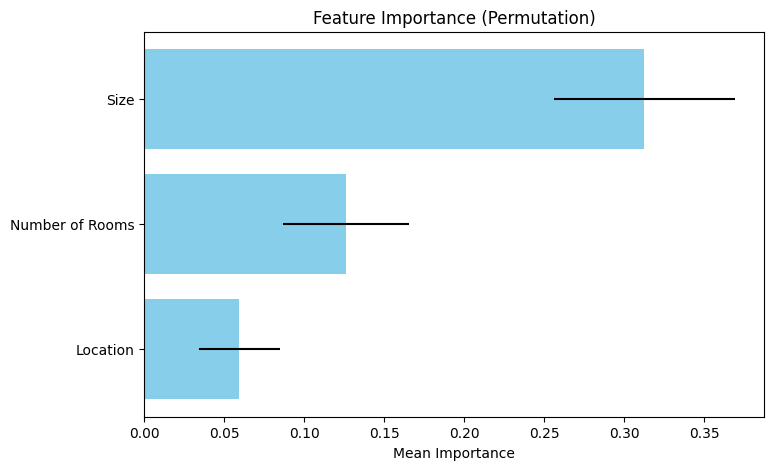

In [20]:
# Step 14 — Feature Insights
import pandas as pd
from sklearn.inspection import permutation_importance

# Get the actual feature names from the transformed dataset
feature_names = X_train.columns

perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create DataFrame safely
perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance_Mean": perm.importances_mean,
    "Importance_Std": perm.importances_std
}).sort_values(by="Importance_Mean", ascending=False)

print("Feature Importance:")
print(perm_df)

# bar plot for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(perm_df["Feature"], perm_df["Importance_Mean"], xerr=perm_df["Importance_Std"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean Importance")
plt.title("Feature Importance (Permutation)")
plt.show()


In [21]:
# Step 15 — Save trained model
import joblib
model_path = "/content/linear_regression_house_prices.joblib"
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")


Model saved to: /content/linear_regression_house_prices.joblib
